# Network Science
## Project: Social Network Analysis (VK)

* Student: Majid Sohrabi
* Program: Data Science

## Imports

In [9]:
import requests
import random
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
import math
%matplotlib inline
import scipy.io
import scipy.stats
import seaborn as sns
import scipy.spatial as spt
from IPython.display import SVG
import pandas as pd
import matplotlib.image as mpimg
from typing import Dict, List
from networkx.algorithms import community
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from scipy.stats import kstest
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.csgraph import reverse_cuthill_mckee

## Read the (.gexf) file

In [10]:
G = nx.read_gexf('vk-friends-MS.gexf').to_undirected()

In [11]:
def delete_unnecessary_attrs(graph, *attrs):
    for node in graph.nodes:
        d_copy = list(graph.nodes[node])
        for key in d_copy:
            if key in attrs:
                del(graph.nodes[node][key])
    return graph

delete_unnecessary_attrs(G, 'nickname', 'photo_50', 'screen_name')

In [12]:
def select_gygantic_component(g: nx.Graph) -> nx.Graph:
    node_list = sorted(nx.connected_components(g), key = len, reverse=True)
    gg = node_list[0]
    len(node_list)
    for i in range(len(node_list) - 1):
        g.remove_nodes_from(node_list[i+1])
    return g

gig_component = G.copy()
gig_component = select_gygantic_component(gig_component)

## Community Detection

Tasks:

1.   Clique search, k-cores visualization, and interpretation.
2.   Best results of various community detection algorithms, both in terms of interpretation and some quality criterion (modularity, silhouette, ground truth partition). 
3.   The results should be visible on the network layout.
4.   Interpretations should be written over image with community detection (use Paint, for e.g.)

1.   Clique search, k-cores visualization, and interpretation.

In [13]:
cliques = list(nx.find_cliques(G))
print("Number of Cliques :", len(cliques))
print("Average clique size", sum([len(clique)/len(cliques) for clique in cliques]))

Number of Cliques : 248
Average clique size 4.762096774193544


In [14]:
def largest_cliques(G):
    color = [random.random(), random.random(), random.random()]
    clique_list = list(nx.find_cliques(G))
    max_clique_length = max([len(i) for i in clique_list])
    largest_cliques = [i for i in clique_list if len(i) == max_clique_length]
    nodes_largest_cliques = list(set([j for i in largest_cliques for j in i]))
    rgb0, rgb1 = [], []
    width1, width2 = [], []
    for node in G.nodes:
        if node in largest_cliques[0]:
            rgb0.append(color)
        else:
            rgb0.append((1, 1, 1))
    for node in G.nodes:    
        if node in largest_cliques[1]:
            rgb1.append(color)
        else:
            rgb1.append((1, 1, 1))
            
    rgb = np.array([rgb0, rgb1])
    
    for edge1, edge2 in G.edges:
        if edge1 in largest_cliques[0] and edge2 in largest_cliques[0]:
            width1.append(2)
        else:
            width1.append(1)
    for edge1, edge2 in G.edges:
        if edge1 in largest_cliques[1] and edge2 in largest_cliques[1]:
            width2.append(2)
        else:
            width2.append(1)
    width = np.array([width1, width2])
    
    return largest_cliques, rgb, width

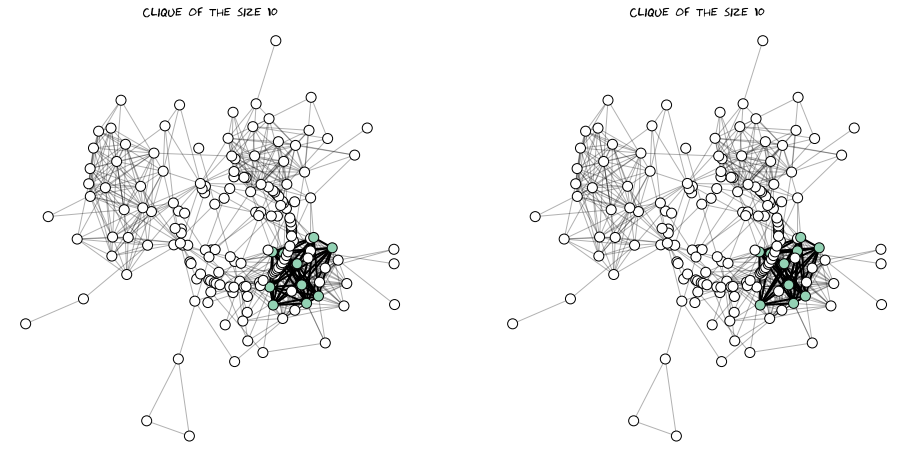

In [15]:
max_cliques, colors, widths = largest_cliques(G)

size = np.unique(colors[0], axis=0, return_counts=True)[1][0]
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(8*2, 8))

for i in range(colors.shape[0]):
    
    b_edges = np.array(list(G.edges))[widths[i] == widths[i].max()]
    
    plt.subplot(1, 2, i+1)
    nodes = nx.draw_networkx_nodes(
        G, 
        pos,
        node_color=colors[i], 
        node_size=100, 
        linewidths=1, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.3,
        width=widths[i].min()
    )
    nx.draw_networkx_edges(
        G,
        pos,
        width=widths[i].max(),
        edgelist=b_edges
    )
    plt.title('Clique of the size {}'.format(size))
    plt.axis('off')

In [16]:
def customized_color(name_cmap, alpha):
  cmap = plt.get_cmap(name_cmap)
  custom_cmap = cmap(np.arange(cmap.N))
  custom_cmap[:,-1] = np.linspace(alpha, 1, cmap.N)
  custom_cmap = ListedColormap(custom_cmap)
  return custom_cmap

def pos_layout(g):
  df = pd.DataFrame(index=g.nodes(), columns=g.nodes())
  for row, data in nx.shortest_path_length(g):
      for col, dist in data.items():
          df.loc[row,col] = dist

  df = df.fillna(df.max().max())
  return df
df_g = pos_layout(G)
pos = nx.kamada_kawai_layout(G, dist=df_g.to_dict())

In [17]:
def k_core_decompose(G):
    return np.array(list(nx.core_number(G).values()))

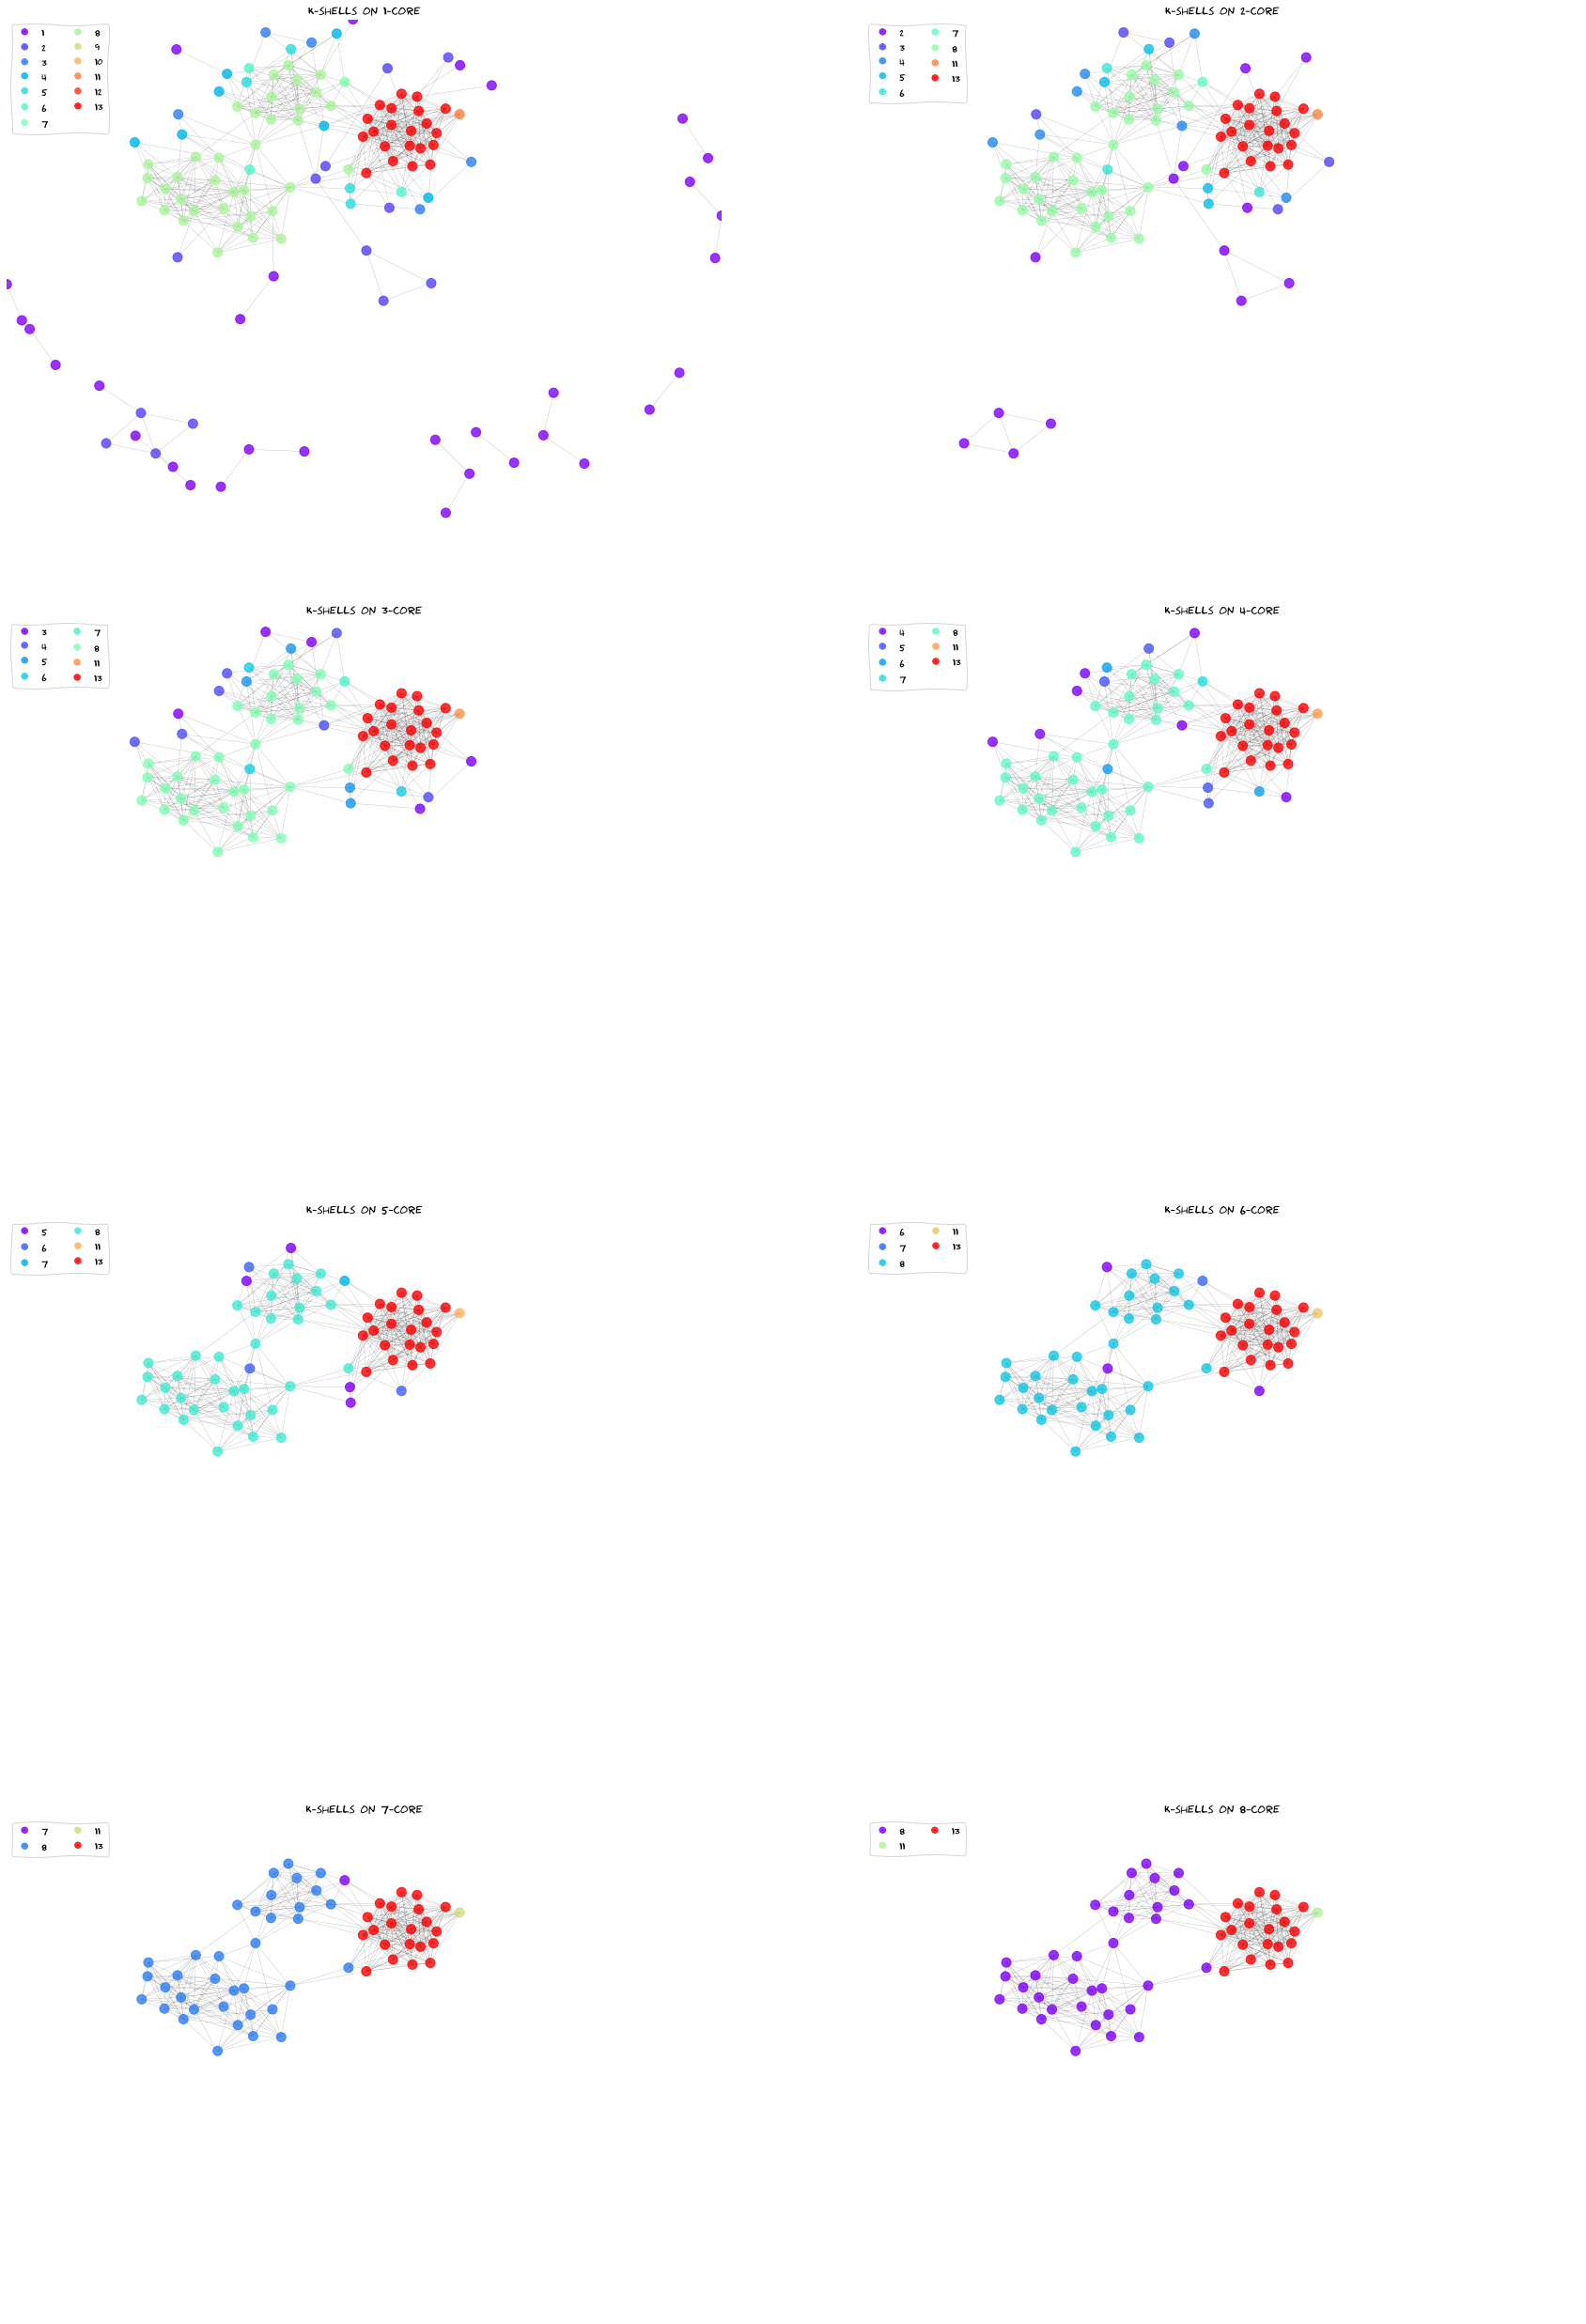

In [18]:
my_cmap = customized_color('plasma', 0.4)
plt.figure(figsize=(30, 45))

x_max, y_max = np.array(list(pos.values())).max(axis=0)
x_min, y_min = np.array(list(pos.values())).min(axis=0)

for i in range(8):
    plt.subplot(4, 2, i+1)
    subG = nx.k_core(G, i+1)
    nodes = nx.draw_networkx_nodes(
        subG, 
        pos=pos,
        cmap=plt.get_cmap('rainbow'),
        node_color=k_core_decompose(subG), 
        node_size=100,
        alpha=0.8
    )
    nx.draw_networkx_edges(
        subG, 
        pos=pos,
        width=0.1
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(*nodes.legend_elements(), loc="upper left", ncol=len(nodes.legend_elements()))
    plt.axis('off')
    plt.title('k-shells on {}-core'.format(i+1))

2.   Best results of various community detection algorithms, both in terms of interpretation and some quality criterion (modularity, silhouette, ground truth partition).
3.   The results should be visible on the network layout.
4.   Interpretations should be written over image with community detection (use Paint, for e.g.)

Modularity

In [19]:
def edge_betw_modularity(G, n):
    res = []
    comm_gen = nx.algorithms.community.girvan_newman(G)
    for i in range(n):
        part = next(comm_gen)
        res.append(nx.algorithms.community.modularity(G, part))
    return np.array(res)

n_iterations = 20
modularity = edge_betw_modularity(G, n_iterations)

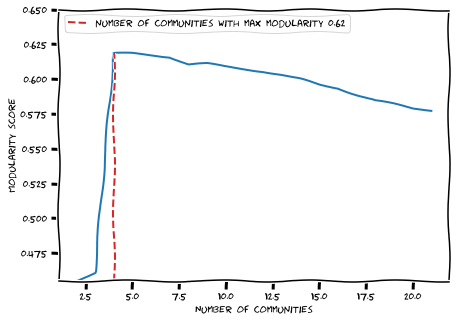

In [20]:
plt.figure(figsize=(7, 5))
plt.plot(np.arange(n_iterations)+2, modularity)
best_n = np.argmax(modularity) + 2
label = 'number of communities with max modularity {:.2f}'.format(max(modularity))
plt.plot(
    [best_n, best_n], [min(modularity), max(modularity)], 
    'k--', c='tab:red', 
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.ylim((modularity.min(), 0.65))
plt.show()

In [21]:
def edge_betweenness(G, n):
    Gcopy = G.copy()
    curr_cc_count = nx.number_connected_components(Gcopy)
    result = []
    while curr_cc_count <= n:
        edge_btw = nx.edge_betweenness_centrality(Gcopy)
        cut_edge = sorted(edge_btw.keys(), key=lambda x: edge_btw[x])[-1]
        Gcopy.remove_edge(*cut_edge)
        if nx.number_connected_components(Gcopy) > curr_cc_count:
            iter_result = np.zeros((Gcopy.number_of_nodes()))
            for idx, cc in enumerate(nx.connected_components(Gcopy)):
                iter_result[np.isin(G.nodes, list(cc))] = idx
            result.append(iter_result)
            curr_cc_count += 1
    return np.array(result)

labels = edge_betweenness(G, 6)

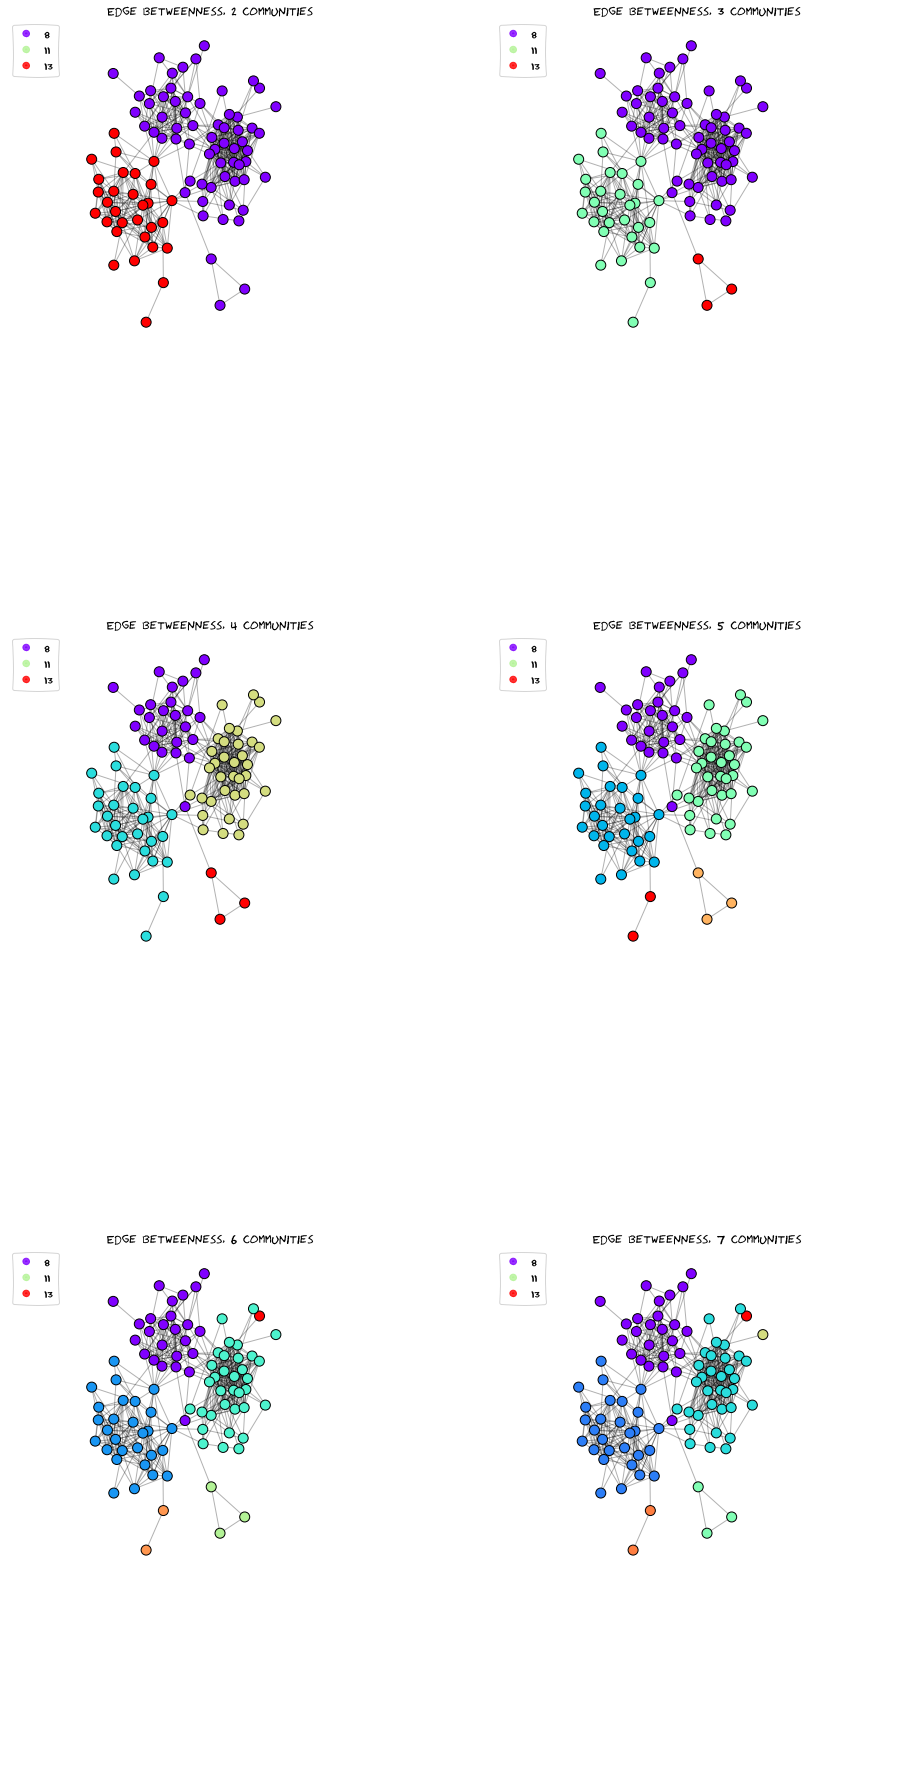

In [22]:
plt.figure(figsize=(8*2, 8*4))
colors = edge_betweenness(gig_component, 6)
for i in range(colors.shape[0]):
    plt.subplot(3, 2, i+1)
    nx.draw_networkx_nodes(
        gig_component, 
        pos,
        cmap=plt.cm.rainbow,
        node_color=colors[i], 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(gig_component, pos, alpha=0.3)
    
    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min-eps, x_max+eps)
    plt.ylim(y_min-eps, y_max+eps)
    plt.legend(*nodes.legend_elements(), loc="upper left")
    plt.axis('off')
    plt.title('Edge betweenness, {} communities'.format(i+2))

Laplacian Eigenmaps

In [23]:
def norm_laplacian(A):
    node_degrees = np.array(A.sum(axis=1))
    D = node_degrees**-0.5
    D_prime = np.diag(D)
    L = np.matmul(np.matmul(D_prime, (np.diag(node_degrees)-A)), D_prime)
    vals, vecs = np.linalg.eigh(L)
    pos = np.argsort(vals)
    vecs = vecs[:, pos]
    vals = vals[pos]
    for i in range(len(node_degrees)):
        vecs[i] /= np.sqrt(1/node_degrees[i])
    
    laplacian_eigenmaps = vecs[:, 1:]
    k_means = KMeans(len(node_degrees)).fit(laplacian_eigenmaps)
    
    return L, k_means.labels_


def spectral_embedding(L, degree_seq, n_components):
    vals, vecs = np.linalg.eigh(L)
    pos = np.argsort(vals)
    vecs = vecs[:, pos]
    vals = vals[pos]
    return vecs[:, 1: n_components+1]


def spectral_clustering(G, n_clusters, n_components):
    A = nx.to_numpy_array(G)
    L, degree_seq = norm_laplacian(A)
    embedding = spectral_embedding(L, degree_seq, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    return kmeans.labels_

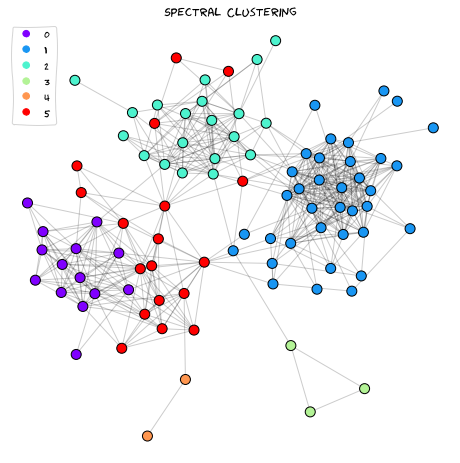

In [24]:
plt.figure(figsize=(8, 8))
nodes = nx.draw_networkx_nodes(
    gig_component, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=spectral_clustering(gig_component, 6, 5), 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    gig_component,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.legend(*nodes.legend_elements(), loc="upper left")
plt.title('Spectral Clustering')
plt.show()

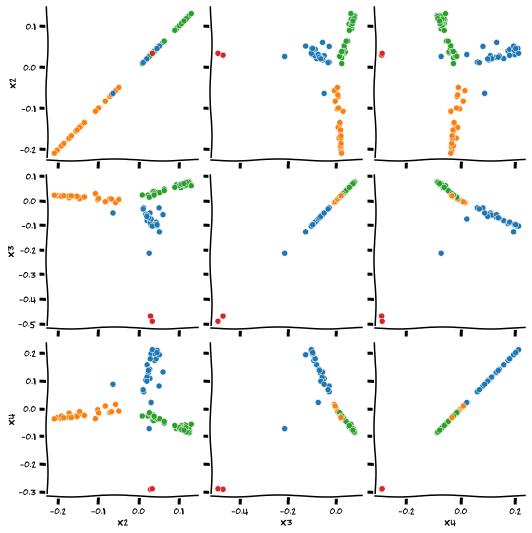

In [25]:
A = nx.to_numpy_array(gig_component)
L, degree_seq = norm_laplacian(A)

embedding = spectral_embedding(L, degree_seq, 3)
labels = spectral_clustering(gig_component, 4, 3)
pair_data = pd.DataFrame(
    np.hstack([embedding, labels[:, None]]), 
    columns=['x2', 'x3', 'x4', 'label'])
pair_data.label = pair_data.label.astype('str')
p = sns.pairplot(
    pair_data,
    hue='label',
    diag_kind=None
)
p._legend.remove()
plt.show()

In [26]:
def simrank_distance(G):
    return np.around(1 - nx.simrank_similarity_numpy(G), decimals = 7)



def agglomerative_clustering(distance, max_distance):
    clusters = AgglomerativeClustering(n_clusters=None,
                                       affinity='precomputed',
                                       compute_full_tree=True,
                                       linkage='complete', 
                                       distance_threshold=max_distance)
    clusters.fit(distance)
    return clusters.labels_

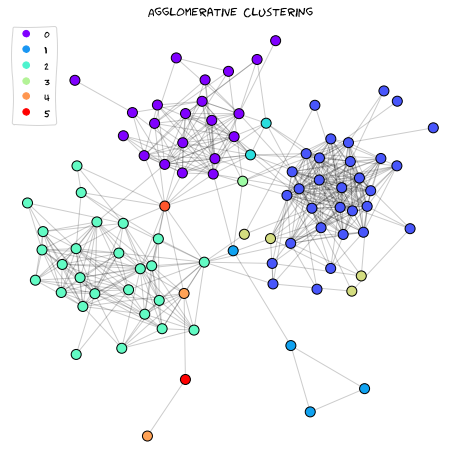

In [27]:
distance = simrank_distance(gig_component)
labels = agglomerative_clustering(distance, 0.87)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    gig_component, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    gig_component,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.legend(*nodes.legend_elements(), loc="upper left")
plt.title('Agglomerative Clustering')
plt.axis('off')
plt.show()